In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, os, pathlib

import torch
import torch.nn as nn
from torch.utils import data

## MNIST dataset

In [2]:
import datasets
from classes import DistanceRegressor, \
                LogisticRegression, ConvexNN, BasicInvexNet, LipschitzInvexNet

In [3]:
mnist = datasets.MNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

train_size = len(train_label_)

In [4]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [5]:
input_size = 784
output_size = 10

learning_rate = 0.0001
batch_size = 50

In [6]:
len(train_data)//batch_size

1200

In [7]:
network_seeds = [147, 258, 369]
network_seed = 369

EPOCHS = 20

actf = nn.LeakyReLU

learning_rate = 0.005
lambda_ = 2
criterion = nn.BCELoss()
sigmoid = nn.Sigmoid()

use_mixup = True

In [8]:
class MNIST_OneClass_Balanced(data.Dataset):
    
    def __init__(self, data, label, class_index):
        self.data = data
        self.label = label
        self.class_index = class_index
        
        mask = (label==class_index)
        self.label = mask.type(torch.float32).reshape(-1,1)
        self.class_data = torch.nonzero(mask).reshape(-1)
        self.other_data = torch.nonzero(~mask).reshape(-1)
        
        random.seed(network_seed)
        self._shuffle_data_()
        self.count = 0
        
    def __len__(self):
        return 2*len(self.class_data)
    
    def _shuffle_data_(self):
#         randidx = np.random.permutation(len(self.other_data))
        randidx = random.sample(range(len(self.other_data)), k=len(self.other_data))
        self.other_data = self.other_data[randidx]
    
    def __getitem__(self, idx):
        if idx < len(self.class_data):
            idx = self.class_data[idx]
            img, lbl = self.data[idx], self.label[idx]
        else:
            idx = self.other_data[idx-len(self.class_data)]
            img, lbl = self.data[idx], self.label[idx]
            self.count += 1
            if self.count >= len(self.class_data): 
                self._shuffle_data_()
                self.count = 0
        return img, lbl

In [9]:
# class_idx = 0
# train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
# test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

In [10]:
# len(train_dataset), len(test_dataset)

In [11]:
# train_loader_all = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
# test_loader_all = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [12]:
# %matplotlib inline
# # img, lbl = train_dataset[11010]
# img, lbl = test_dataset[10]
# print(lbl)
# plt.imshow(img.reshape(28,28))

## Logistic Regression

In [13]:
# class_idx = 0
stat_per_class = []
net_list = []
for class_idx in range(10):
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    logNet = LogisticRegression(784)
    optimizer = torch.optim.Adam(logNet.parameters(), lr=learning_rate)

    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1

            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(logNet(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            preds = (yy.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == preds).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

            if index%200 == 0:
                train_accs.append(float(train_acc)/train_count*100)
                train_acc = 0
                train_count = 0

                print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
                test_count = 0
                test_acc = 0
                for xx, yy in test_loader:
                    with torch.no_grad():
                        yout = logNet(xx)
                    outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
                    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                    test_acc += correct
                    test_count += len(xx)
                test_accs.append(float(test_acc)/test_count*100)
                print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
                print("\n")
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(logNet)

Epoch: 0:200,  Loss:0.5145545601844788
Train Acc:50.19%, Test Acc:97.86%


Epoch: 1:400,  Loss:0.5180794596672058
Train Acc:50.23%, Test Acc:98.37%


Epoch: 2:600,  Loss:0.49276816844940186
Train Acc:50.68%, Test Acc:98.67%


Epoch: 3:800,  Loss:0.47931113839149475
Train Acc:51.96%, Test Acc:98.62%


Epoch: 4:1000,  Loss:0.5393970608711243
Train Acc:52.35%, Test Acc:98.62%


Epoch: 5:1200,  Loss:0.5352065563201904
Train Acc:55.47%, Test Acc:98.67%


Epoch: 5:1400,  Loss:0.5227574110031128
Train Acc:54.43%, Test Acc:98.67%


Epoch: 6:1600,  Loss:0.5396431684494019
Train Acc:55.88%, Test Acc:98.67%


Epoch: 7:1800,  Loss:0.5722149610519409
Train Acc:58.11%, Test Acc:98.72%


Epoch: 8:2000,  Loss:0.5416309237480164
Train Acc:59.77%, Test Acc:98.72%


Epoch: 9:2200,  Loss:0.5448659658432007
Train Acc:61.73%, Test Acc:98.72%


Epoch: 10:2400,  Loss:0.47605592012405396
Train Acc:64.13%, Test Acc:98.83%


Epoch: 10:2600,  Loss:0.5507673025131226
Train Acc:62.40%, Test Acc:98.83%


Epoch: 11:2

Train Acc:61.60%, Test Acc:96.38%


Epoch: 7:1800,  Loss:0.5752459764480591
Train Acc:63.23%, Test Acc:96.28%


Epoch: 8:2000,  Loss:0.48756495118141174
Train Acc:64.34%, Test Acc:96.44%


Epoch: 9:2200,  Loss:0.5136403441429138
Train Acc:65.23%, Test Acc:96.38%


Epoch: 10:2400,  Loss:0.5440595149993896
Train Acc:67.37%, Test Acc:96.54%


Epoch: 11:2600,  Loss:0.5845538973808289
Train Acc:68.62%, Test Acc:96.64%


Epoch: 11:2800,  Loss:0.5023119449615479
Train Acc:68.25%, Test Acc:96.69%


Epoch: 12:3000,  Loss:0.4997398257255554
Train Acc:68.49%, Test Acc:96.44%


Epoch: 13:3200,  Loss:0.5358188152313232
Train Acc:69.97%, Test Acc:96.54%


Epoch: 14:3400,  Loss:0.5366041660308838
Train Acc:69.98%, Test Acc:96.64%


Epoch: 15:3600,  Loss:0.5245886445045471
Train Acc:71.33%, Test Acc:96.59%


Epoch: 16:3800,  Loss:0.5042750835418701
Train Acc:71.68%, Test Acc:96.59%


Epoch: 17:4000,  Loss:0.47352486848831177
Train Acc:74.09%, Test Acc:96.59%


Epoch: 17:4200,  Loss:0.5423820614814758


Train Acc:60.00%, Test Acc:91.07%


Epoch: 17:4200,  Loss:0.5907708406448364
Train Acc:60.27%, Test Acc:91.12%


Epoch: 18:4400,  Loss:0.527740478515625
Train Acc:60.89%, Test Acc:91.12%


Epoch: 19:4600,  Loss:0.5166277885437012
Train Acc:60.98%, Test Acc:91.22%


Class: 8 -> Train Acc 60.977777777777774 ; Test Acc 91.22176591375771 

Epoch: 0:200,  Loss:0.5678597092628479
Train Acc:50.26%, Test Acc:91.28%


Epoch: 1:400,  Loss:0.523908793926239
Train Acc:51.80%, Test Acc:92.17%


Epoch: 2:600,  Loss:0.5640270113945007
Train Acc:55.66%, Test Acc:92.67%


Epoch: 3:800,  Loss:0.511634111404419
Train Acc:57.33%, Test Acc:93.11%


Epoch: 4:1000,  Loss:0.5540332198143005
Train Acc:59.38%, Test Acc:93.06%


Epoch: 5:1200,  Loss:0.5439659357070923
Train Acc:60.40%, Test Acc:92.96%


Epoch: 5:1400,  Loss:0.5291340351104736
Train Acc:62.60%, Test Acc:93.11%


Epoch: 6:1600,  Loss:0.5902145504951477
Train Acc:63.59%, Test Acc:93.26%


Epoch: 7:1800,  Loss:0.563675582408905
Train Acc:65.00%, Tes

In [14]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    shuffle_data()
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(net(xx).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 72.57731958762886 ; Test Acc 98.87755102040816
Class: 1 -> Train Acc 88.0 ; Test Acc 98.54625550660792
Class: 2 -> Train Acc 68.3061224489796 ; Test Acc 95.44573643410853
Class: 3 -> Train Acc 71.0 ; Test Acc 95.0
Class: 4 -> Train Acc 74.0909090909091 ; Test Acc 96.79226069246437
Class: 5 -> Train Acc 62.0 ; Test Acc 94.05829596412556
Class: 6 -> Train Acc 76.67164179104478 ; Test Acc 97.28601252609603
Class: 7 -> Train Acc 78.25806451612904 ; Test Acc 96.49805447470817
Class: 8 -> Train Acc 60.977777777777774 ; Test Acc 91.22176591375771
Class: 9 -> Train Acc 73.25641025641025 ; Test Acc 93.35976214073341
Total Accuracy (Argmax) is : 0.9154000282287598


In [ ]:
sum([p.numel() for p in net.parameters()])

## Convex

In [15]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = ConvexNN([784,200,100,1], actf)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1
        
            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            preds = (yy.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == preds).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)


            if index%200 == 0:
                train_accs.append(float(train_acc)/train_count*100)
                train_acc = 0
                train_count = 0

                print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
                test_count = 0
                test_acc = 0
                for xx, yy in test_loader:
                    with torch.no_grad():
                        yout = sigmoid(Net(xx))
                    outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
                    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                    test_acc += correct
                    test_count += len(xx)
                test_accs.append(float(test_acc)/test_count*100)
                print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
                print("\n")
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:200,  Loss:0.1902083456516266
Train Acc:96.30%, Test Acc:98.42%


Epoch: 1:400,  Loss:0.16477316617965698
Train Acc:98.49%, Test Acc:98.47%


Epoch: 2:600,  Loss:0.14492975175380707
Train Acc:98.76%, Test Acc:98.42%


Epoch: 3:800,  Loss:0.11025704443454742
Train Acc:99.30%, Test Acc:99.13%


Epoch: 4:1000,  Loss:0.12073925137519836
Train Acc:99.38%, Test Acc:98.83%


Epoch: 5:1200,  Loss:0.13998454809188843
Train Acc:99.33%, Test Acc:99.34%


Epoch: 5:1400,  Loss:0.14511480927467346
Train Acc:99.54%, Test Acc:99.13%


Epoch: 6:1600,  Loss:0.11947750300168991
Train Acc:99.52%, Test Acc:99.18%


Epoch: 7:1800,  Loss:0.12466155737638474
Train Acc:99.62%, Test Acc:99.59%


Epoch: 8:2000,  Loss:0.13368499279022217
Train Acc:99.81%, Test Acc:99.08%


Epoch: 9:2200,  Loss:0.08891221880912781
Train Acc:99.82%, Test Acc:99.13%


Epoch: 10:2400,  Loss:0.12346048653125763
Train Acc:99.80%, Test Acc:99.18%


Epoch: 10:2600,  Loss:0.12881770730018616
Train Acc:99.83%, Test Acc:99.18%




Train Acc:99.27%, Test Acc:98.42%


Epoch: 6:1600,  Loss:0.1950913816690445
Train Acc:99.45%, Test Acc:98.47%


Epoch: 7:1800,  Loss:0.11146356910467148
Train Acc:99.57%, Test Acc:98.47%


Epoch: 8:2000,  Loss:0.14711014926433563
Train Acc:99.64%, Test Acc:98.57%


Epoch: 9:2200,  Loss:0.113343246281147
Train Acc:99.72%, Test Acc:98.52%


Epoch: 10:2400,  Loss:0.12928034365177155
Train Acc:99.73%, Test Acc:98.37%


Epoch: 11:2600,  Loss:0.10810442268848419
Train Acc:99.77%, Test Acc:98.22%


Epoch: 11:2800,  Loss:0.13461264967918396
Train Acc:99.82%, Test Acc:98.57%


Epoch: 12:3000,  Loss:0.12525875866413116
Train Acc:99.83%, Test Acc:98.37%


Epoch: 13:3200,  Loss:0.14600667357444763
Train Acc:99.77%, Test Acc:98.37%


Epoch: 14:3400,  Loss:0.08760692924261093
Train Acc:99.84%, Test Acc:98.57%


Epoch: 15:3600,  Loss:0.1081419587135315
Train Acc:99.89%, Test Acc:98.42%


Epoch: 16:3800,  Loss:0.1541793942451477
Train Acc:99.75%, Test Acc:98.73%


Epoch: 17:4000,  Loss:0.1098400577902

Train Acc:99.31%, Test Acc:96.30%


Epoch: 16:3800,  Loss:0.13254430890083313
Train Acc:99.30%, Test Acc:96.82%


Epoch: 17:4000,  Loss:0.15160377323627472
Train Acc:99.60%, Test Acc:96.20%


Epoch: 17:4200,  Loss:0.14640316367149353
Train Acc:99.41%, Test Acc:96.61%


Epoch: 18:4400,  Loss:0.13230390846729279
Train Acc:99.58%, Test Acc:96.46%


Epoch: 19:4600,  Loss:0.13300004601478577
Train Acc:99.70%, Test Acc:96.82%


Class: 8 -> Train Acc 99.70370370370371 ; Test Acc 96.81724845995893 

9
Epoch: 0:200,  Loss:0.25558242201805115
Train Acc:89.37%, Test Acc:92.77%


Epoch: 1:400,  Loss:0.3021601736545563
Train Acc:93.90%, Test Acc:93.95%


Epoch: 2:600,  Loss:0.24361030757427216
Train Acc:95.05%, Test Acc:94.90%


Epoch: 3:800,  Loss:0.21518684923648834
Train Acc:95.74%, Test Acc:94.55%


Epoch: 4:1000,  Loss:0.2558193504810333
Train Acc:95.71%, Test Acc:95.14%


Epoch: 5:1200,  Loss:0.21317631006240845
Train Acc:97.00%, Test Acc:95.09%


Epoch: 5:1400,  Loss:0.1474662572145462
Train

In [16]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 100.0 ; Test Acc 99.59183673469387
Class: 1 -> Train Acc 100.0 ; Test Acc 99.51541850220265
Class: 2 -> Train Acc 99.0 ; Test Acc 98.11046511627907
Class: 3 -> Train Acc 100.0 ; Test Acc 98.46534653465346
Class: 4 -> Train Acc 100.0 ; Test Acc 98.77800407331976
Class: 5 -> Train Acc 99.82978723404256 ; Test Acc 97.92600896860986
Class: 6 -> Train Acc 99.87628865979381 ; Test Acc 98.95615866388309
Class: 7 -> Train Acc 100.0 ; Test Acc 98.44357976653697
Class: 8 -> Train Acc 99.70370370370371 ; Test Acc 96.81724845995893
Class: 9 -> Train Acc 99.05128205128206 ; Test Acc 95.98612487611497
Total Accuracy (Argmax) is : 0.9660000205039978


In [ ]:
sum([p.numel() for p in net.parameters()])

## NN

In [17]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = nn.Sequential(nn.Linear(784, 200),
                       actf(),
                       nn.Linear(200,100),
                       actf(),
                       nn.Linear(100,1))
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1

            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            preds = (yy.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == preds).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

            if index%200 == 0:
                train_accs.append(float(train_acc)/train_count*100)
                train_acc = 0
                train_count = 0

                print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
                test_count = 0
                test_acc = 0
                for xx, yy in test_loader:
                    with torch.no_grad():
                        yout = sigmoid(Net(xx))
                    outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
                    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                    test_acc += correct
                    test_count += len(xx)
                test_accs.append(float(test_acc)/test_count*100)
                print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
                print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:200,  Loss:0.21731796860694885
Train Acc:97.29%, Test Acc:99.29%

Epoch: 1:400,  Loss:0.12151513993740082
Train Acc:98.92%, Test Acc:99.39%

Epoch: 2:600,  Loss:0.11258745193481445
Train Acc:99.44%, Test Acc:99.34%

Epoch: 3:800,  Loss:0.11354289203882217
Train Acc:99.73%, Test Acc:99.29%

Epoch: 4:1000,  Loss:0.1234457939863205
Train Acc:99.73%, Test Acc:99.39%

Epoch: 5:1200,  Loss:0.13944566249847412
Train Acc:99.87%, Test Acc:99.34%

Epoch: 5:1400,  Loss:0.11360175162553787
Train Acc:99.91%, Test Acc:99.39%

Epoch: 6:1600,  Loss:0.18856018781661987
Train Acc:99.89%, Test Acc:99.49%

Epoch: 7:1800,  Loss:0.09785205125808716
Train Acc:100.00%, Test Acc:99.54%

Epoch: 8:2000,  Loss:0.1420046091079712
Train Acc:99.96%, Test Acc:99.44%

Epoch: 9:2200,  Loss:0.09902246296405792
Train Acc:99.94%, Test Acc:99.44%

Epoch: 10:2400,  Loss:0.11073046922683716
Train Acc:99.93%, Test Acc:99.49%

Epoch: 10:2600,  Loss:0.12462783604860306
Train Acc:99.98%, Test Acc:99.44%

Epoch: 11:280

Train Acc:99.76%, Test Acc:98.42%

Epoch: 7:1800,  Loss:0.11900530755519867
Train Acc:99.95%, Test Acc:98.63%

Epoch: 8:2000,  Loss:0.11467210948467255
Train Acc:99.86%, Test Acc:98.57%

Epoch: 9:2200,  Loss:0.10531017929315567
Train Acc:99.66%, Test Acc:98.63%

Epoch: 10:2400,  Loss:0.09614083170890808
Train Acc:99.97%, Test Acc:98.73%

Epoch: 11:2600,  Loss:0.12361001968383789
Train Acc:99.92%, Test Acc:99.13%

Epoch: 11:2800,  Loss:0.10536752641201019
Train Acc:99.88%, Test Acc:98.78%

Epoch: 12:3000,  Loss:0.1102680116891861
Train Acc:99.86%, Test Acc:98.63%

Epoch: 13:3200,  Loss:0.12229945510625839
Train Acc:99.91%, Test Acc:98.83%

Epoch: 14:3400,  Loss:0.1066506952047348
Train Acc:99.89%, Test Acc:98.57%

Epoch: 15:3600,  Loss:0.1212250292301178
Train Acc:99.84%, Test Acc:98.37%

Epoch: 16:3800,  Loss:0.10433226823806763
Train Acc:100.00%, Test Acc:98.78%

Epoch: 17:4000,  Loss:0.12613998353481293
Train Acc:100.00%, Test Acc:98.73%

Epoch: 17:4200,  Loss:0.10448730736970901
Tra

Epoch: 17:4200,  Loss:0.111699178814888
Train Acc:99.85%, Test Acc:97.95%

Epoch: 18:4400,  Loss:0.09885604679584503
Train Acc:99.87%, Test Acc:98.56%

Epoch: 19:4600,  Loss:0.10521125793457031
Train Acc:99.93%, Test Acc:98.61%

Class: 8 -> Train Acc 100.0 ; Test Acc 98.81930184804928 

9
Epoch: 0:200,  Loss:0.16223327815532684
Train Acc:92.94%, Test Acc:96.78%

Epoch: 1:400,  Loss:0.13000811636447906
Train Acc:97.56%, Test Acc:97.08%

Epoch: 2:600,  Loss:0.10350021719932556
Train Acc:98.37%, Test Acc:97.82%

Epoch: 3:800,  Loss:0.17198461294174194
Train Acc:98.88%, Test Acc:97.82%

Epoch: 4:1000,  Loss:0.11707755923271179
Train Acc:99.17%, Test Acc:97.97%

Epoch: 5:1200,  Loss:0.12492135167121887
Train Acc:99.40%, Test Acc:97.92%

Epoch: 5:1400,  Loss:0.14391696453094482
Train Acc:99.33%, Test Acc:97.97%

Epoch: 6:1600,  Loss:0.12057922035455704
Train Acc:99.63%, Test Acc:98.36%

Epoch: 7:1800,  Loss:0.14173611998558044
Train Acc:99.58%, Test Acc:98.27%

Epoch: 8:2000,  Loss:0.0931264

In [18]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 100.0 ; Test Acc 99.54081632653062
Class: 1 -> Train Acc 100.0 ; Test Acc 99.47136563876651
Class: 2 -> Train Acc 100.0 ; Test Acc 99.03100775193798
Class: 3 -> Train Acc 100.0 ; Test Acc 98.76237623762376
Class: 4 -> Train Acc 100.0 ; Test Acc 99.13441955193483
Class: 5 -> Train Acc 100.0 ; Test Acc 99.04708520179372
Class: 6 -> Train Acc 100.0 ; Test Acc 99.37369519832986
Class: 7 -> Train Acc 100.0 ; Test Acc 98.92996108949417
Class: 8 -> Train Acc 100.0 ; Test Acc 98.81930184804928
Class: 9 -> Train Acc 99.91176470588236 ; Test Acc 98.86025768087215
Total Accuracy (Argmax) is : 0.9782999753952026


In [ ]:
sum([p.numel() for p in net.parameters()])

# Invex (Basic)

In [12]:
# use_mixup = True

use_check = False
check_every = 2
check_size = 100

m_,s_ = 1, 0

In [13]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    lips_net = nn.Sequential(nn.Linear(784, 200),
                       actf(),
                       nn.Linear(200,100),
                       actf(),
                       nn.Linear(100,1))
    Net = BasicInvexNet(784, lips_net, lambda_)
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1
            
            optimizer.zero_grad()
            if use_check and epoch%check_every == 0:
                rand_inp = torch.rand(check_size, 784)*m_+s_
                Net(rand_inp)
                Net.compute_penalty_and_clipper()
                Net.gp.backward(retain_graph=True)
            
            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))   
            Net.compute_penalty_and_clipper()
            loss = criterion(yout, y_mix) + Net.gp
            losses.append(float(loss))

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            preds = (yy.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == preds).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

            loss.backward()
            optimizer.step()

#             if index%200 == 0:
        train_accs.append(float(train_acc)/train_count*100)
        train_acc = 0
        train_count = 0

        min_val, gp = float(Net.cond.min()) , float(Net.gp)
        print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}, MinVal:{min_val}, gp: {gp}')
        test_count = 0
        test_acc = 0
        for xx, yy in test_loader:
#                     with torch.no_grad():
            yout = sigmoid(Net(xx))
            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
            test_acc += correct
            test_count += len(xx)
        test_accs.append(float(test_acc)/test_count*100)
        print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
        print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:237,  Loss:0.12104102969169617, MinVal:0.20007428526878357, gp: 2.4546026907046326e-05
Train Acc:95.12%, Test Acc:99.29%

Epoch: 1:474,  Loss:0.15531833469867706, MinVal:0.40670931339263916, gp: 7.073840180282787e-09
Train Acc:99.12%, Test Acc:99.39%

Epoch: 2:711,  Loss:0.14841140806674957, MinVal:0.33301666378974915, gp: 1.918551788548939e-07
Train Acc:99.47%, Test Acc:99.13%

Epoch: 3:948,  Loss:0.16003890335559845, MinVal:0.3883458971977234, gp: 1.3284091160414846e-08
Train Acc:99.67%, Test Acc:99.39%

Epoch: 4:1185,  Loss:0.10901155322790146, MinVal:0.4834924042224884, gp: 2.981085378550574e-10
Train Acc:99.76%, Test Acc:99.39%

Epoch: 5:1422,  Loss:0.1428469717502594, MinVal:0.5995229482650757, gp: 3.5862903358802045e-12
Train Acc:99.83%, Test Acc:99.39%

Epoch: 6:1659,  Loss:0.10806393623352051, MinVal:0.5254332423210144, gp: 5.528042607005901e-11
Train Acc:99.92%, Test Acc:99.34%

Epoch: 7:1896,  Loss:0.11802355200052261, MinVal:0.38442763686180115, gp: 1.55254298306

Train Acc:97.33%, Test Acc:97.62%

Epoch: 2:738,  Loss:0.2579522430896759, MinVal:0.9157487154006958, gp: 3.522387172901498e-17
Train Acc:98.33%, Test Acc:97.87%

Epoch: 3:984,  Loss:0.0866110697388649, MinVal:1.067868947982788, gp: 8.058648790258751e-20
Train Acc:98.50%, Test Acc:97.62%

Epoch: 4:1230,  Loss:0.08276137709617615, MinVal:1.4664192199707031, gp: 9.542370428716439e-27
Train Acc:99.09%, Test Acc:98.51%

Epoch: 5:1476,  Loss:0.06854762881994247, MinVal:0.9897899031639099, gp: 1.8174632507231894e-18
Train Acc:99.31%, Test Acc:98.32%

Epoch: 6:1722,  Loss:0.11424312740564346, MinVal:0.7926135063171387, gp: 4.839157249420705e-15
Train Acc:99.53%, Test Acc:98.02%

Epoch: 7:1968,  Loss:0.13340745866298676, MinVal:0.6408939361572266, gp: 3.2939872617737675e-12
Train Acc:99.76%, Test Acc:98.71%

Epoch: 8:2214,  Loss:0.11985883861780167, MinVal:0.9218805432319641, gp: 3.0532831213553254e-17
Train Acc:99.68%, Test Acc:98.32%

Epoch: 9:2460,  Loss:0.09526341408491135, MinVal:0.612130

Epoch: 3:948,  Loss:0.1171061173081398, MinVal:0.8065006732940674, gp: 1.2391737323283751e-15
Train Acc:99.65%, Test Acc:99.22%

Epoch: 4:1185,  Loss:0.13307207822799683, MinVal:0.6736098527908325, gp: 1.8935219603215259e-13
Train Acc:99.76%, Test Acc:99.32%

Epoch: 5:1422,  Loss:0.10934246331453323, MinVal:0.367171049118042, gp: 3.948982296719805e-08
Train Acc:99.83%, Test Acc:99.16%

Epoch: 6:1659,  Loss:0.17450660467147827, MinVal:0.9343262910842896, gp: 5.9458751590658944e-18
Train Acc:99.82%, Test Acc:99.01%

Epoch: 7:1896,  Loss:0.15111902356147766, MinVal:0.6262035369873047, gp: 1.346725465520282e-12
Train Acc:99.86%, Test Acc:99.32%

Epoch: 8:2133,  Loss:0.12530896067619324, MinVal:0.7280295491218567, gp: 2.135929440586458e-14
Train Acc:99.88%, Test Acc:99.01%

Epoch: 9:2370,  Loss:0.1148197129368782, MinVal:0.7322417497634888, gp: 1.8047602258139395e-14
Train Acc:99.97%, Test Acc:99.48%

Epoch: 10:2607,  Loss:0.12849532067775726, MinVal:1.0373705625534058, gp: 9.03214149730107

Train Acc:98.93%, Test Acc:98.22%

Epoch: 5:1428,  Loss:0.191964253783226, MinVal:0.6854758262634277, gp: 8.92496796953135e-14
Train Acc:99.18%, Test Acc:96.93%

Epoch: 6:1666,  Loss:0.15352167189121246, MinVal:0.7116934657096863, gp: 3.0837887853105844e-14
Train Acc:99.48%, Test Acc:97.77%

Epoch: 7:1904,  Loss:0.1408618539571762, MinVal:0.5017245411872864, gp: 1.370228097652415e-10
Train Acc:99.45%, Test Acc:97.87%

Epoch: 8:2142,  Loss:0.174640491604805, MinVal:0.4571504294872284, gp: 8.127520323419901e-10
Train Acc:99.44%, Test Acc:96.88%

Epoch: 9:2380,  Loss:0.09769801050424576, MinVal:0.46102654933929443, gp: 1.3471307402923571e-09
Train Acc:99.51%, Test Acc:98.02%

Epoch: 10:2618,  Loss:0.1708209365606308, MinVal:0.4782849848270416, gp: 4.617541626839028e-10
Train Acc:99.65%, Test Acc:97.87%

Epoch: 11:2856,  Loss:0.10379713773727417, MinVal:0.5849847197532654, gp: 5.180172263363758e-12
Train Acc:99.69%, Test Acc:97.87%

Epoch: 12:3094,  Loss:0.11098400503396988, MinVal:0.43787

In [14]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 100.0 ; Test Acc 99.54081632653062
Class: 1 -> Train Acc 99.98516760605162 ; Test Acc 99.55947136563876
Class: 2 -> Train Acc 99.95803961060759 ; Test Acc 98.98255813953489
Class: 3 -> Train Acc 99.95922361768064 ; Test Acc 98.7128712871287
Class: 4 -> Train Acc 99.9743238616912 ; Test Acc 99.13441955193483
Class: 5 -> Train Acc 100.0 ; Test Acc 98.71076233183857
Class: 6 -> Train Acc 100.0 ; Test Acc 99.47807933194154
Class: 7 -> Train Acc 99.99201915403033 ; Test Acc 98.88132295719845
Class: 8 -> Train Acc 99.84618014014698 ; Test Acc 98.35728952772074
Class: 9 -> Train Acc 99.94957135653051 ; Test Acc 98.51337958374629
Total Accuracy (Argmax) is : 0.9746999740600586


In [15]:
sum([p.numel() for p in net.parameters()])

177985

In [16]:
## only on training and testing data
for class_idx in range(10):
    correct = 0
    count = 0
    net = net_list[class_idx]
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)
        
    for index in range(len(train_label) // batch_size):
        xx = train_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    print(f"Class: {class_idx} -> Correct {correct/count*100:.4f}% on {count} input points")

Class: 0 -> Correct 100.0000% on 70000 input points
Class: 1 -> Correct 99.9957% on 70000 input points
Class: 2 -> Correct 99.9529% on 70000 input points
Class: 3 -> Correct 99.9986% on 70000 input points
Class: 4 -> Correct 99.9986% on 70000 input points
Class: 5 -> Correct 100.0000% on 70000 input points
Class: 6 -> Correct 99.9986% on 70000 input points
Class: 7 -> Correct 100.0000% on 70000 input points
Class: 8 -> Correct 100.0000% on 70000 input points
Class: 9 -> Correct 100.0000% on 70000 input points


In [17]:
## Check the constraint on large number of points, including training and test data.
from tqdm import tqdm
for class_idx in range(10):
    correct = 0
    count = 0
    net = net_list[class_idx]
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)
        
    for index in range(len(train_label) // batch_size):
        xx = train_data[index * batch_size:(index + 1) * batch_size]
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    for i in tqdm(range(20000)):
        xx = torch.rand(batch_size, 784)
        net(xx)
        net.compute_penalty_and_clipper()
        correct += (net.cond>0).type(torch.float32).sum()
        count += len(xx)

    print(f"Class: {class_idx} -> Correct {correct/count*100:.4f}% on {count} input points")

100%|██████████████████████████████████████████████| 20000/20000 [00:28<00:00, 706.63it/s]


Class: 0 -> Correct 99.9951% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:28<00:00, 708.62it/s]


Class: 1 -> Correct 99.9997% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:28<00:00, 696.44it/s]


Class: 2 -> Correct 93.0134% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:28<00:00, 692.55it/s]


Class: 3 -> Correct 7.0199% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:28<00:00, 701.66it/s]


Class: 4 -> Correct 99.9999% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:29<00:00, 677.14it/s]


Class: 5 -> Correct 100.0000% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:29<00:00, 680.94it/s]


Class: 6 -> Correct 31.1949% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:28<00:00, 690.65it/s]


Class: 7 -> Correct 88.7164% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:28<00:00, 711.30it/s]


Class: 8 -> Correct 99.9999% on 1070000 input points


100%|██████████████████████████████████████████████| 20000/20000 [00:29<00:00, 684.89it/s]

Class: 9 -> Correct 100.0000% on 1070000 input points


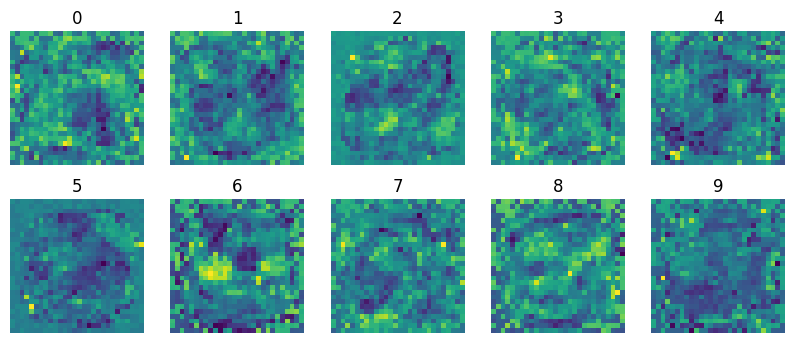

In [18]:
fig, axs = plt.subplots(2,5, figsize=(10,4))
for i in range(10):
    invNet = net_list[i]
    icenter = invNet.center.data
    j, k = i//5, i%5
#     print(i, j, k)
    axs[j,k].imshow(icenter.data.cpu().reshape(28, 28))
    axs[j,k].set_title(f"{i}")
    axs[j,k].set_axis_off()
# fig.tight_layout()
plt.savefig("./invex_out/MNIST_BasicInvex_mlp_centroids.pdf")
plt.show()

## Invertible+Cone = Invex

In [19]:
from nflib.flows import SequentialFlow, ActNorm, ActNorm2D, AffineConstantFlow
from nflib import coupling_flows as icf
from nflib import res_flow as irf

In [20]:
from classes import DistanceRegressor

In [21]:
class InvexInvertible_MNIST(nn.Module):
    
    def __init__(self):
        super().__init__()
        actf = irf.LeakyReLU
        flows = [
            ActNorm(784),
            irf.ResidualFlow(784, [200], activation=actf),
            ActNorm(784),
            irf.ResidualFlow(784, [100], activation=actf),
            ActNorm(784),
            DistanceRegressor(784)
                ]
        self.model = nn.Sequential(*flows)
    
    def forward(self, x):
        return self.model(x)

In [22]:
stat_per_class = []
net_list = []
for class_idx in range(10):
    print(class_idx)
    train_dataset = MNIST_OneClass_Balanced(train_data, train_label, class_idx)
    test_dataset = MNIST_OneClass_Balanced(test_data, test_label, class_idx)

    train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

    torch.manual_seed(network_seed)
    Net = InvexInvertible_MNIST()
    optimizer = torch.optim.Adam(Net.parameters(), lr=learning_rate)
    losses = []
    train_accs = []
    test_accs = []

    index = 0
    for epoch in range(20):
        train_acc = 0
        train_count = 0
        for xx, yy in train_loader:
            index += 1

            if use_mixup:
                rand_indx = np.random.permutation(len(xx))
                rand_lambda = 1-torch.rand(len(xx), 1)*0.1
                x_mix = rand_lambda*xx+(1-rand_lambda)*xx[rand_indx]
                y_mix = rand_lambda*yy+(1-rand_lambda)*yy[rand_indx]
            else:
                x_mix = xx
                y_mix = yy

            yout = sigmoid(Net(x_mix))    
            loss = criterion(yout, y_mix)
            losses.append(float(loss))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
            preds = (yy.data.cpu().numpy() > 0.5).astype(float)
            correct = (outputs == preds).astype(float).sum()
            train_acc += correct
            train_count += len(outputs)

            if index%200 == 0:
                train_accs.append(float(train_acc)/train_count*100)
                train_acc = 0
                train_count = 0

                print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
                test_count = 0
                test_acc = 0
                for xx, yy in test_loader:
                    with torch.no_grad():
                        yout = sigmoid(Net(xx))
                    outputs = (yout.data.cpu().numpy() > 0.5).astype(float)
                    correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
                    test_acc += correct
                    test_count += len(xx)
                test_accs.append(float(test_acc)/test_count*100)
                print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
                print()
                
    ### after each class index is finished training
    stat_per_class.append(
    f'Class: {class_idx} -> Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}'
    )
    print(stat_per_class[-1], '\n')
    net_list.append(Net)

0
Epoch: 0:200,  Loss:2.017425537109375
Train Acc:50.35%, Test Acc:52.19%

Epoch: 1:400,  Loss:0.6552376747131348
Train Acc:87.50%, Test Acc:95.51%

Epoch: 2:600,  Loss:0.2072739452123642
Train Acc:96.78%, Test Acc:97.14%

Epoch: 3:800,  Loss:0.17310529947280884
Train Acc:98.18%, Test Acc:98.01%

Epoch: 4:1000,  Loss:0.16602550446987152
Train Acc:99.12%, Test Acc:98.83%

Epoch: 5:1200,  Loss:0.16733378171920776
Train Acc:99.47%, Test Acc:98.83%

Epoch: 5:1400,  Loss:0.12613587081432343
Train Acc:99.15%, Test Acc:99.13%

Epoch: 6:1600,  Loss:0.13674357533454895
Train Acc:99.30%, Test Acc:99.23%

Epoch: 7:1800,  Loss:0.14135807752609253
Train Acc:99.63%, Test Acc:98.88%

Epoch: 8:2000,  Loss:0.13091380894184113
Train Acc:99.62%, Test Acc:99.18%

Epoch: 9:2200,  Loss:0.09841427206993103
Train Acc:99.79%, Test Acc:99.23%

Epoch: 10:2400,  Loss:0.11937825381755829
Train Acc:99.93%, Test Acc:99.44%

Epoch: 10:2600,  Loss:0.136350616812706
Train Acc:99.78%, Test Acc:99.39%

Epoch: 11:2800,  L

Train Acc:98.97%, Test Acc:98.32%

Epoch: 7:1800,  Loss:0.10955020785331726
Train Acc:99.35%, Test Acc:98.42%

Epoch: 8:2000,  Loss:0.1232694610953331
Train Acc:99.62%, Test Acc:98.63%

Epoch: 9:2200,  Loss:0.11858807504177094
Train Acc:99.70%, Test Acc:98.42%

Epoch: 10:2400,  Loss:0.14607833325862885
Train Acc:99.70%, Test Acc:98.47%

Epoch: 11:2600,  Loss:0.12774574756622314
Train Acc:99.92%, Test Acc:98.83%

Epoch: 11:2800,  Loss:0.11941848695278168
Train Acc:99.74%, Test Acc:98.73%

Epoch: 12:3000,  Loss:0.1337575912475586
Train Acc:99.78%, Test Acc:98.78%

Epoch: 13:3200,  Loss:0.12724687159061432
Train Acc:99.84%, Test Acc:98.47%

Epoch: 14:3400,  Loss:0.13762296736240387
Train Acc:99.95%, Test Acc:98.78%

Epoch: 15:3600,  Loss:0.09280382096767426
Train Acc:99.78%, Test Acc:98.93%

Epoch: 16:3800,  Loss:0.1346178650856018
Train Acc:99.82%, Test Acc:98.78%

Epoch: 17:4000,  Loss:0.12188203632831573
Train Acc:100.00%, Test Acc:98.63%

Epoch: 17:4200,  Loss:0.10668226331472397
Trai

Epoch: 17:4200,  Loss:0.11203169822692871
Train Acc:99.21%, Test Acc:97.95%

Epoch: 18:4400,  Loss:0.13841086626052856
Train Acc:99.54%, Test Acc:97.54%

Epoch: 19:4600,  Loss:0.12653276324272156
Train Acc:99.76%, Test Acc:97.18%

Class: 8 -> Train Acc 99.76363636363637 ; Test Acc 98.04928131416838 

9
Epoch: 0:200,  Loss:3.8268680572509766
Train Acc:50.65%, Test Acc:58.92%

Epoch: 1:400,  Loss:0.39498671889305115
Train Acc:84.62%, Test Acc:89.54%

Epoch: 2:600,  Loss:0.39874622225761414
Train Acc:91.58%, Test Acc:92.77%

Epoch: 3:800,  Loss:0.2958671748638153
Train Acc:94.65%, Test Acc:93.95%

Epoch: 4:1000,  Loss:0.18153978884220123
Train Acc:96.38%, Test Acc:95.44%

Epoch: 5:1200,  Loss:0.16779470443725586
Train Acc:97.60%, Test Acc:96.33%

Epoch: 5:1400,  Loss:0.24734318256378174
Train Acc:97.24%, Test Acc:96.63%

Epoch: 6:1600,  Loss:0.1678840070962906
Train Acc:97.92%, Test Acc:97.08%

Epoch: 7:1800,  Loss:0.15801995992660522
Train Acc:98.22%, Test Acc:97.22%

Epoch: 8:2000,  Los

In [23]:
## find the classification error from classification per class network.
acc_test = 0
count_test = 0
with torch.no_grad():
    for index in range(len(test_label) // batch_size):
        xx = test_data[index * batch_size:(index + 1) * batch_size]
        yy = test_label[index * batch_size:(index + 1) * batch_size]
        yout = []
        for net in net_list:
            yout.append(sigmoid(net(xx)).reshape(-1))
        yout = torch.stack(yout, dim=1).argmax(dim=1)
        acc = (yout == yy).type(torch.float32).sum()
        count_test += len(xx)
        acc_test += acc
        
for s in stat_per_class:
    print(s)
print(f"Total Accuracy (Argmax) is : {float(acc_test/count_test)}")

Class: 0 -> Train Acc 100.0 ; Test Acc 99.48979591836735
Class: 1 -> Train Acc 100.0 ; Test Acc 99.51541850220265
Class: 2 -> Train Acc 100.0 ; Test Acc 99.03100775193798
Class: 3 -> Train Acc 99.92727272727274 ; Test Acc 98.31683168316832
Class: 4 -> Train Acc 100.0 ; Test Acc 99.03258655804481
Class: 5 -> Train Acc 99.98198198198199 ; Test Acc 98.65470852017937
Class: 6 -> Train Acc 100.0 ; Test Acc 99.16492693110646
Class: 7 -> Train Acc 99.88372093023256 ; Test Acc 98.34630350194551
Class: 8 -> Train Acc 99.76363636363637 ; Test Acc 98.04928131416838
Class: 9 -> Train Acc 99.8 ; Test Acc 98.16650148662042
Total Accuracy (Argmax) is : 0.9725000262260437


In [24]:
sum([p.numel() for p in net.parameters()])

477758

#### Visualize Centers

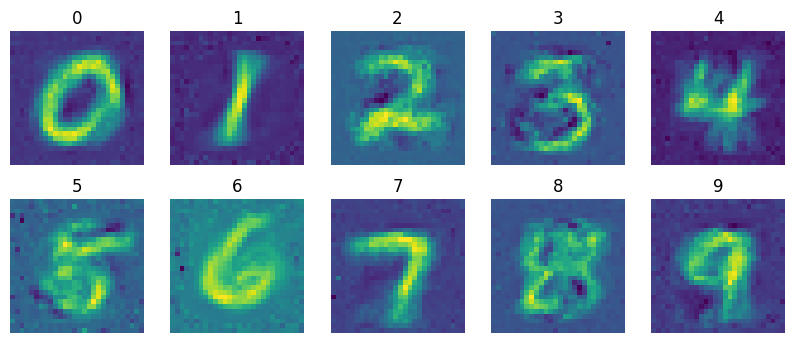

In [25]:
fig, axs = plt.subplots(2,5, figsize=(10,4))
for i in range(10):
    invNet = net_list[i]
    invertible = SequentialFlow([*invNet.model[:-1]])## excluding distance regressor
    icenter = invertible.inverse(invNet.model[-1].centers.data)
    j, k = i//5, i%5
#     print(i, j, k)
    axs[j,k].imshow(icenter.data.cpu().reshape(28, 28))
    axs[j,k].set_title(f"{i}")
    axs[j,k].set_axis_off()
# fig.tight_layout()
plt.savefig("./invex_out/MNIST_InvertibleInvex_mlp_centroids.pdf")
plt.show()